# INTRODUCTION









<img src="https://img.evbuc.com/https%3A%2F%2Fcdn.evbuc.com%2Fimages%2F24945955%2F175508455052%2F2%2Foriginal.jpg?w=200&auto=format%2Ccompress&q=75&sharp=10&s=a4894a26eb70fdd64e08589de6b38c1f">
 
WeCloudData is the leading data science education and career service provider in Canada. WeCloudData has been training devoted and passionate data scientists for solving challenging business problems in data analytics. Besides, career mentorship is also a critical part of the school to provide continued guidance to its graduated students during their job-seeking process. This project is to build up a machine-learning algorithm that helps identify the employment status of the recently graduated WeCloudData alumni from their Linkedin profiles. The suggested approach by the client (WeCloudData) is to identify the presence of the green ‘open-to-work’ frame on the Linkedin profile images. To fullfil this task, this notebook includes the training, testing, and application of a CNN model as described by the following.

# MOUNT & TEST GPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Check GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
## Compare GPU with CPU
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.7461239750000175
GPU (s):
0.037891129999991335
GPU speedup over CPU: 72x


# IMPORT LIBRARIES

In [ ]:
import os
from tensorflow import keras
import seaborn as sns 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from matplotlib import image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.utils import class_weight

# IMPORT & EXAMINE TRAIN/TEST DATASETS

In [ ]:
#Create a function to calculate the files in a directory
def calculate_files(link):
    return (len([name for name in os.listdir(link)]))

In [ ]:
train_regular = calculate_files('/content/drive/My Drive/partnership/linkedin_profile_images/train/regular')
train_open = calculate_files('/content/drive/My Drive/partnership/linkedin_profile_images/train/open-to-work')
test_regular = calculate_files('/content/drive/My Drive/partnership/linkedin_profile_images/test/regular')
test_open = calculate_files('/content/drive/My Drive/partnership/linkedin_profile_images/test/open-to-work')

In [ ]:
#Create a dataframe with count of each class in the train dataset
train_barplot = pd.DataFrame({'number_of_images':[train_regular,train_open], 'status':['regular', 'open']})
display(train_barplot)

,number_of_images,status
0,40,regular
1,40,open


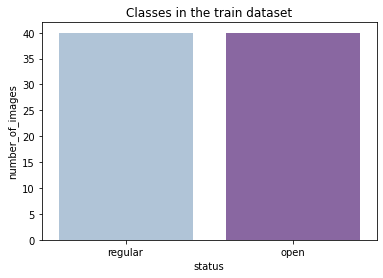

In [ ]:
#Plot classes of the train dataset
sns.barplot(y = 'number_of_images', x = 'status', 
            data = train_barplot,
            palette=("BuPu")).set_title('Classes in the train dataset');

In [ ]:
#Create a dataframe with count of each class in the test dataset 
test_barplot = pd.DataFrame({'number_of_images':[test_regular,test_open], 'status':['regular', 'open']})
display(test_barplot)

,number_of_images,status
0,10,regular
1,10,open


Display Random Images


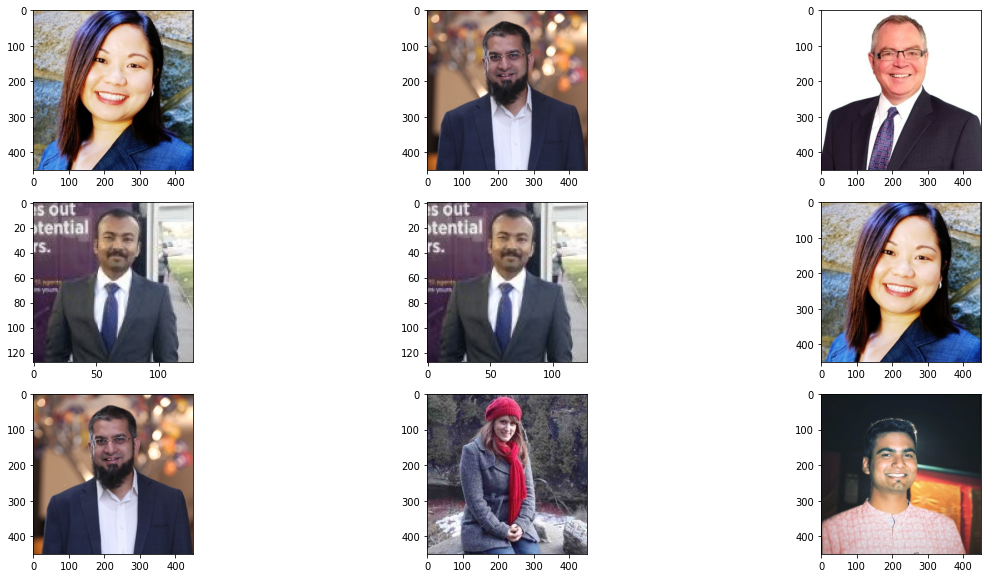

In [ ]:
# Extract numpy values from regular test/regular directory
images = [name for name in os.listdir('/content/drive/My Drive/partnership/linkedin_profile_images/test/regular')]

#set a pseudorandom generator to consistency
np.random.seed(42)
random_images = [np.random.choice(images, replace = False) for i in range(9)]

# Location of the image dir
img_dir = '/content/drive/My Drive/partnership/linkedin_profile_images/test/regular'

print('Display Random Images')

# Adjust the size of the images
plt.figure(figsize=(20,10))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(img_dir,random_images[i]))
    plt.imshow(img,cmap='gray') 

# CONVERT IMAGE DATA TO ML IPUTS

In [ ]:
#Create image generators
train_datagen = ImageDataGenerator(
    samplewise_center=True, #Set each sample mean to 0.
    samplewise_std_normalization= True, # Divide each input by its standard deviation
    rotation_range=10,#Degree range for random rotations.
    width_shift_range=0.1,#fraction of total width rotation
    height_shift_range=0.1,#fraction of total height rotation
    rescale=1./255,#Scale the pixels to [0,1]
    validation_split = 0.2) #Fraction of images reserved for validation

test_datagen = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization= True, 
    rescale=1./255)

The maximum pixel value is 255.0000 and the minimum is 2.0000
The mean value of the pixels is 106.9928 and the standard deviation is 64.2312


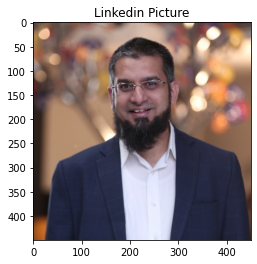

In [ ]:
# Get the first image from test/normal directory
first_image = images[0]
img1 = plt.imread(os.path.join(img_dir,first_image))
plt.imshow(img1,cmap='gray')

pixels = image.imread(os.path.join(img_dir,first_image))

plt.title('Linkedin Picture')
#print(f"The dimensions of the image are {img1.width} pixels width and {img1.height} pixels height, mode of the image is {img.mode}")
print(f"The maximum pixel value is {pixels.max():.4f} and the minimum is {pixels.min():.4f}")
print(f"The mean value of the pixels is {pixels.mean():.4f} and the standard deviation is {pixels.std():.4f}")

In [ ]:
#Load images in to train, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    directory=r"/content/drive/My Drive/partnership/linkedin_profile_images/train/",
    classes = ['regular','open-to-work'],
    class_mode='categorical',
    target_size=(800, 800),
    color_mode="rgb",
    batch_size=64,
    
    shuffle=True,
    subset = "training",
    seed=42
)

valid_generator = train_datagen.flow_from_directory(
    directory=r"/content/drive/My Drive/partnership/linkedin_profile_images/train/",
    classes = ['regular','open-to-work'],
    class_mode='categorical',
    target_size=(800, 800),
    color_mode="rgb",
    batch_size=64,
    
    shuffle=True,
    subset = "validation",
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=r"/content/drive/My Drive/partnership/linkedin_profile_images/test/",
    
    class_mode='categorical',
    target_size=(800, 800),
    color_mode="rgb",
    batch_size=64,
    
    shuffle=False,
    seed = 42
)

Found 64 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [ ]:
test_generator.filenames

['open-to-work/1595903478891.jpeg',
 'open-to-work/1597744124421.jpeg',
 'open-to-work/1597769507281.jpeg',
 'open-to-work/1597934556821.jpeg',
 'open-to-work/1599303172736.jpeg',
 'open-to-work/1602172954483.jpeg',
 'open-to-work/1602247966483.jpeg',
 'open-to-work/1603133115730.jpeg',
 'open-to-work/1603709297408.jpeg',
 'open-to-work/1605107737667.jpeg',
 'regular/1516276756805.jpeg',
 'regular/1516290858359.jpeg',
 'regular/1516353839391.jpeg',
 'regular/1517011166720.jpeg',
 'regular/1517436964577.jpeg',
 'regular/1517439942233.jpeg',
 'regular/1517533952625.jpeg',
 'regular/1517632456803.jpeg',
 'regular/1517714282109.jpeg',
 'regular/1517751670309.jpeg']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


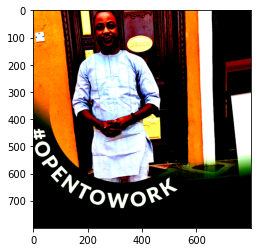

In [ ]:
#Visualize a first image after preprocessing from the train set
x_train, y_train = valid_generator.__getitem__(0)
plt.imshow(x_train[0]);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


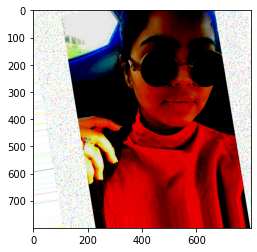

In [ ]:
#Visualize a first image after preprocessing from the validation set
x_val, y_val = train_generator.__getitem__(0)
plt.imshow(x_val[0]);

# ML ALGORITHM DEVELOPMENT

In [ ]:
## Obtain the bias coefficient of the train set
initial_bias = np.log([train_open/train_regular])
initial_bias

array([0.])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,SGD

In [ ]:
#define a default treshold 0.5 probability for identification
def treshold(pred):
    if pred <= 0.5:
        return 0
    else:
        return 1

In [ ]:
## Transfer Learning Approach using pre-trained DenseNet121 Model
## DenseNet121 Model
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', input_shape= (800, 800, 3), include_top=False)

#freeze the base model.
base_model.trainable = False

inputs = keras.Input(shape= (800, 800, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
x = Flatten()(x)
## Finalized with 3 dense layers
x = tf.keras.layers.Dense(128, activation='relu') (x)
x = tf.keras.layers.Dense(64, activation='relu') (x)
x = tf.keras.layers.Dense(16, activation='relu') (x)
outputs = keras.layers.Dense(1, activation = 'sigmoid', 
                             bias_initializer=keras.initializers.Constant(initial_bias)
)(x)
model = keras.Model(inputs, outputs)
## Model training oriented by binary accuracy as the dataset is evently balanced
model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=keras.metrics.BinaryAccuracy())

In [ ]:
## Model training using the dataset from train_generator (training dataset) 23mins
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

model.fit(train_generator, 
          validation_data=valid_generator,
          batch_size=1,
          steps_per_epoch=1,      
          validation_steps=1, 
          callbacks = early_stopping_cb,
          epochs = 54)

Epoch 1/54
1/1 [==============================] - 27s 27s/step - loss: 0.6822 - binary_accuracy: 0.5000 - val_loss: 0.6618 - val_binary_accuracy: 0.5000
Epoch 2/54
1/1 [==============================] - 17s 17s/step - loss: 0.6429 - binary_accuracy: 0.5000 - val_loss: 0.6298 - val_binary_accuracy: 0.6875
Epoch 3/54
1/1 [==============================] - 15s 15s/step - loss: 0.6076 - binary_accuracy: 0.7188 - val_loss: 0.6128 - val_binary_accuracy: 0.8750
Epoch 4/54
1/1 [==============================] - 15s 15s/step - loss: 0.5663 - binary_accuracy: 0.9531 - val_loss: 0.5695 - val_binary_accuracy: 0.9375
Epoch 5/54
1/1 [==============================] - 15s 15s/step - loss: 0.5265 - binary_accuracy: 0.9531 - val_loss: 0.5282 - val_binary_accuracy: 0.8750
Epoch 6/54
1/1 [==============================] - 15s 15s/step - loss: 0.4827 - binary_accuracy: 0.9062 - val_loss: 0.4970 - val_binary_accuracy: 0.9375
Epoch 7/54
1/1 [==============================] - 15s 15s/step - loss: 0.4390 - bi

In [ ]:
## develop a function which evaluates the model using  4 different matrices
def assess_model(model):
    predicted_vals = model.predict(test_generator, steps = len(test_generator))
    vfunc = np.vectorize(treshold)
    predictions = vfunc(predicted_vals)
    accuracy = accuracy_score(test_generator.classes, predictions)
    print('Accuracy: %f' % accuracy)
    print()
    f1 = f1_score(test_generator.classes, predictions)
    print('F1 score: %f' % f1)
    print()
    precision = precision_score(test_generator.classes, predictions)
    print('Precision_score : %f' % precision)
    print()
    recall = recall_score(test_generator.classes, predictions)
    print('Recall_score: %f' % recall)
    print()
    print('Confusion matrix')
    cm = confusion_matrix(y_true=test_generator.classes, y_pred=predictions)
    print(cm)

In [ ]:
# Assess the model using the data from test_generator (test set)
assess_model(model)

Accuracy: 1.000000

F1 score: 1.000000

Precision_score : 1.000000

Recall_score: 1.000000

Confusion matrix
[[10  0]
 [ 0 10]]


In [ ]:
model.save('/content/drive/My Drive/partnership/DenseNet.h5')

# MODEL USE

# New Section

In [ ]:
# Load saved model
from keras.models import load_model


model = load_model('/content/drive/My Drive/partnership/DenseNet.h5')

In [ ]:
# Prepare new uncategorized images as input (test3_generater)
test3_generator = test_datagen.flow_from_directory(
    directory=r"/content/drive/My Drive/partnership/linkedin_profile_images/test3/",
    target_size=(800, 800),
    color_mode="rgb",
    batch_size=64,
    class_mode=None,
    shuffle=False,
    seed = 42
)
x_test3 = test3_generator.__getitem__(0)

Found 11 images belonging to 1 classes.


In [ ]:
# Use model to predict test3_generator (the new uncategorized data)
prediction3 = model.predict(test3_generator, steps = len(test3_generator))
prediction3

# When the label is close to 1, it has a high probability as regular. Otherwise, it is likely to be 'open-to-work'

array([[9.8049700e-01],
       [9.7797352e-01],
       [9.7137964e-01],
       [9.9986327e-01],
       [9.9232990e-01],
       [2.4831623e-03],
       [2.0602094e-04],
       [1.4843547e-01],
       [9.9888605e-01],
       [9.1435050e-04],
       [2.0972427e-03]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input dat

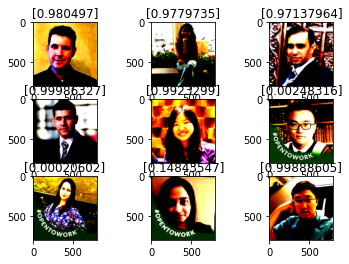

In [ ]:
# Attach predictions labels with the corresponding input images
for i in range(9):
    plt.subplot(3,3,i+1)
    img = x_test3[i]
    plt.title(prediction3[i])
    plt.imshow(img,cmap='gray')
# All images are well annotated